In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

9528


In [2]:
# Required plotting setting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')

from ImageAnalysis3.figure_tools import _single_col_width, _font_size, _ticklabel_size,_ticklabel_width, _double_col_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

In [3]:
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
print(postanalysis_folder)
figure_folder = os.path.join(postanalysis_folder, 'Figures_0817')
print(figure_folder)

comp_figure_folder = os.path.join(figure_folder, 'AB_compartment')

if not os.path.exists(comp_figure_folder):
    print(f"Create: {comp_figure_folder}")
    os.makedirs(comp_figure_folder)
else:
    print(f"Use: {comp_figure_folder}")


\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis
\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\Figures_0817
Use: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\Figures_0817\AB_compartment


## load codebook

In [4]:
# function to compress the hi-c count map by binning the previusoly merged bins
def compress_hic_map (hic_count_map, compress_size =1): 
    
    print(f'-- Input count map shape is {hic_count_map.shape}.')
    if len(hic_count_map.shape) !=2 or hic_count_map.shape[0]!=hic_count_map.shape[1]:
        print(f'-- Input count map is invalid.')
        return None
    
    # add empty pseduo bins if the last ctp loci does not have enough hic bins to merge
    if len(hic_count_map)%compress_size !=0:
        print(f'-- Add empty bins to the input map to enable the compression.')
        residual = len(hic_count_map)%compress_size
        add_num = compress_size - residual 
        new_dim = len(hic_count_map)+add_num
        new_hic_count_map = np.zeros([new_dim,new_dim])
        new_hic_count_map[:len(hic_count_map),:len(hic_count_map)]=hic_count_map
        hic_count_map =new_hic_count_map
        
    print(f'-- Summing the input count map over every {compress_size} loci')
    # reshape to split the rows into (splitted_rows, compress_size, cols ) and sum the splitted_row along the compression-axis
    new_row_num = int(hic_count_map.shape[-1]/compress_size)
    sum_count_row = hic_count_map.reshape(new_row_num,compress_size,hic_count_map.shape[-1]).sum(1) #sum along axis 1
    # reshape to split the col into (splitted_rows, compress_size, splitted_cols) and splitted_cols along the compression-axis
    new_col_num = new_row_num
    sum_count_row_col = sum_count_row.reshape(new_row_num,new_col_num,compress_size).sum(2) #sum along axis 2
    #print(sum_count_row_col.shape)
    
    return sum_count_row_col

In [5]:
import pandas as pd
from ImageAnalysis3.structure_tools import distance
# load codebook
codebook = pd.read_csv(r'\\10.245.74.158\Chromatin_NAS_8\Exported_data\20220713-Export\merged_codebook.csv')
# partition by chr
chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook, codebook, sort_by_region=False)

In [6]:
hic_save_folder = r'W:\HiC_cortex\hic_map_cortex_20kb'

hic_reg_df = pd.read_csv(os.path.join(hic_save_folder, 'filtered_regions.csv'), )


hic_files = [os.path.join(hic_save_folder,_fl) for _fl in os.listdir(hic_save_folder) if 'HiC_20kb_chr_' in _fl]
chr_2_hic_raw = {}
for _fl in hic_files:
    _hic_mat = np.load(_fl)
    _chr = os.path.basename(_fl).split('.npy')[0].split('_')[-1]
    chr_2_hic_raw[_chr] = _hic_mat



In [8]:
sel_chr = '7'
_chr_hic_raw = chr_2_hic_raw[sel_chr]
# df
_chr_reg_df = hic_reg_df.loc[hic_reg_df['chr']==int(sel_chr)]
_chr_reg_starts = _chr_reg_df['start'].values

In [9]:
# merge resolution
merge_bins = 3
merged_hic_map = compress_hic_map(_chr_hic_raw, merge_bins)
merged_gstarts = _chr_reg_starts[::merge_bins]

from scipy.spatial.distance import pdist, squareform
_gdist_map = squareform(pdist(merged_gstarts[:,np.newaxis]))

-- Input count map shape is (7273, 7273).
-- Add empty bins to the input map to enable the compression.
-- Summing the input count map over every 3 loci


In [16]:
gdist_entries = _gdist_map[np.triu_indices(len(_gdist_map),1)]
hic_entries = merged_hic_map[np.triu_indices(len(merged_hic_map),1)]
# collapse along distances
dists = np.unique(gdist_entries)

valid_dists = []
mean_counts = []
zero_fracs = []
for _d in dists:
    _cts = hic_entries[np.where(gdist_entries==_d)]
    _zero_fr = np.mean(_cts==0)
    if _zero_fr < 1:
        valid_dists.append(_d)
        mean_counts.append(np.mean(_cts))
        zero_fracs.append(_zero_fr)
hic_lr = scipy.stats.linregress(np.log(valid_dists), np.log(mean_counts))
print(hic_lr)
hic_poly = np.polyfit(np.log(valid_dists), np.log(mean_counts) ,deg=5)

LinregressResult(slope=-0.9095704332686297, intercept=14.768732966896458, rvalue=-0.9113958642872502, pvalue=0.0, stderr=0.008454259952227431, intercept_stderr=0.15047802076992803)


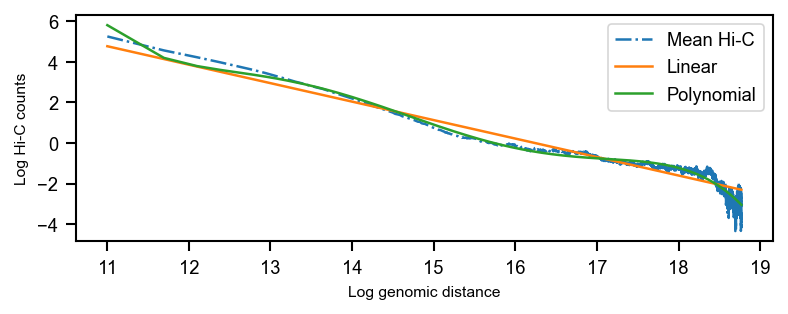

In [17]:
%matplotlib inline
plt.figure(figsize=(6,2), dpi=150)
plt.plot(np.log(valid_dists), np.log(mean_counts), '-.', label='Mean Hi-C')
plt.plot(np.log(valid_dists), (np.log(valid_dists) * hic_lr.slope + hic_lr.intercept), '-', label='Linear')
plt.plot(np.log(valid_dists), np.polyval(hic_poly, np.log(valid_dists)), label='Polynomial')
plt.xlabel("Log genomic distance")
plt.ylabel("Log Hi-C counts")
plt.legend()
plt.show()

In [18]:
hic_gdist_norm = np.exp(np.polyval(hic_poly, np.log(_gdist_map)))

C:\Users\puzheng\AppData\Local\Temp/ipykernel_9528/2724077451.py:1: RuntimeWarning: divide by zero encountered in log
  hic_gdist_norm = np.exp(np.polyval(hic_poly, np.log(_gdist_map)))
E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\numpy\lib\polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [19]:
hic_gdist_norm = np.exp(np.polyval(hic_poly, np.log(_gdist_map)))
hic_gdist_norm[np.arange(len(hic_gdist_norm)),np.arange(len(hic_gdist_norm))] = 1e10
hic_normed_map = merged_hic_map / hic_gdist_norm

from scipy.ndimage import gaussian_filter
from numpy import ma

gaussian_sigma = 1.5
valid_inds = np.where(hic_normed_map.sum(0) > 0)[0]

hic_corr_map = np.corrcoef(gaussian_filter(hic_normed_map[valid_inds, valid_inds[:,np.newaxis]], gaussian_sigma))
#hic_corr_map = ma.corrcoef(ma.masked_invalid(hic_normed_map))

C:\Users\puzheng\AppData\Local\Temp/ipykernel_9528/2160019596.py:1: RuntimeWarning: divide by zero encountered in log
  hic_gdist_norm = np.exp(np.polyval(hic_poly, np.log(_gdist_map)))


<IPython.core.display.Javascript object>


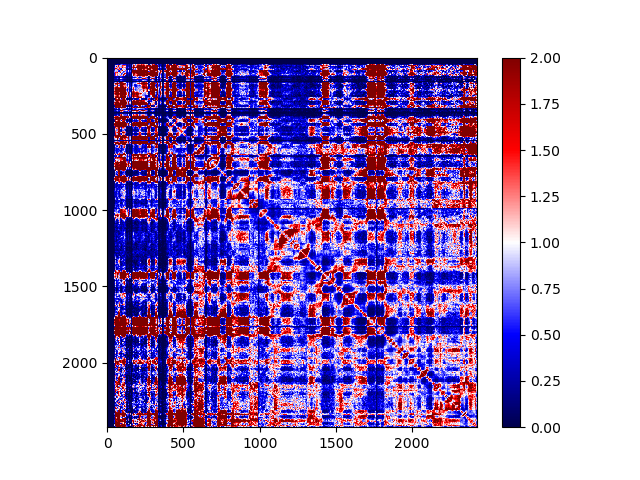

In [20]:
%matplotlib notebook
plt.style.use('default')
plt.figure(dpi=100)
plt.imshow(hic_normed_map, vmin=0, vmax=2, cmap='seismic')#norm=LogNorm(0.1,5))
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


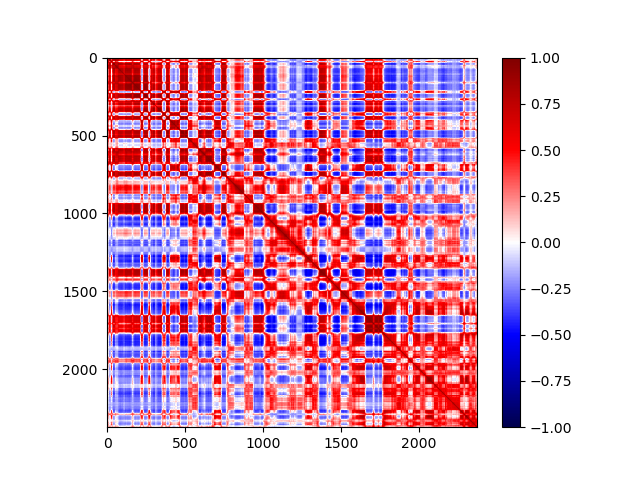

In [21]:
plt.figure(dpi=100)
plt.imshow(hic_corr_map, vmin=-1, vmax=1, cmap='seismic')#norm=LogNorm(0.1,5))
plt.colorbar()
plt.show()

In [22]:
from sklearn.decomposition import PCA
hic_model = PCA(1)
hic_model.fit(hic_corr_map)
hic_pc1 = np.reshape(hic_model.fit_transform(hic_corr_map), -1)

In [23]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

<IPython.core.display.Javascript object>


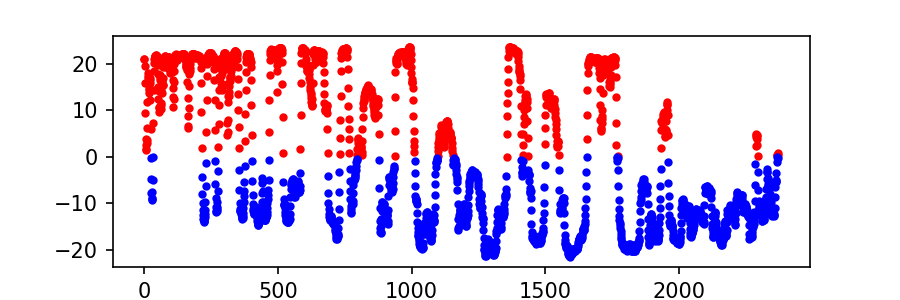

In [24]:
hic_fig, hic_ax = plt.subplots(figsize=(6,2),dpi=150)
hic_ax.plot(np.where(hic_pc1>=0)[0], hic_pc1[np.where(hic_pc1>=0)[0]], '.', linewidth=1, color='r', label='A')
hic_ax.plot(np.where(hic_pc1<0)[0], hic_pc1[np.where(hic_pc1<0)[0]], '.', linewidth=1, color='b', label='B')
plt.show()

# map to region in codebook

In [28]:
chr_codebook = codebook[codebook['chr']==sel_chr]

In [34]:
valid_starts = merged_gstarts[valid_inds]

reg_hic_inds = []
for _n in chr_codebook['name']:
    _start, _end = _n.split(':')[1].split('-') 
    _center = (int(_start)+int(_end))/2
    reg_hic_inds.append(np.argmin(np.abs(valid_starts-_center)))

In [35]:
sort_order = np.argsort(chr_codebook['chr_order'].values.astype(np.int32))
matched_pc1 = hic_pc1[np.array(reg_hic_inds)[sort_order]]


In [45]:
matched_pc1 = (matched_pc1 * -1 ) / np.std(matched_pc1)

<IPython.core.display.Javascript object>


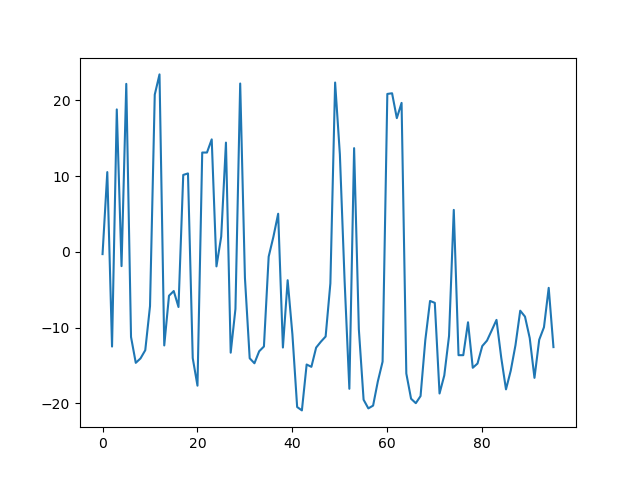

In [36]:
plt.plot(matched_pc1)

In [37]:
ensemble_pc1_filename = os.path.join(postanalysis_folder, 'ensemble_pc1.npy')

ensemble_normed_PC1 = np.load(ensemble_pc1_filename)


In [40]:
chr_normedPC1 = ensemble_normed_PC1[chr_2_indices[sel_chr]]

<IPython.core.display.Javascript object>


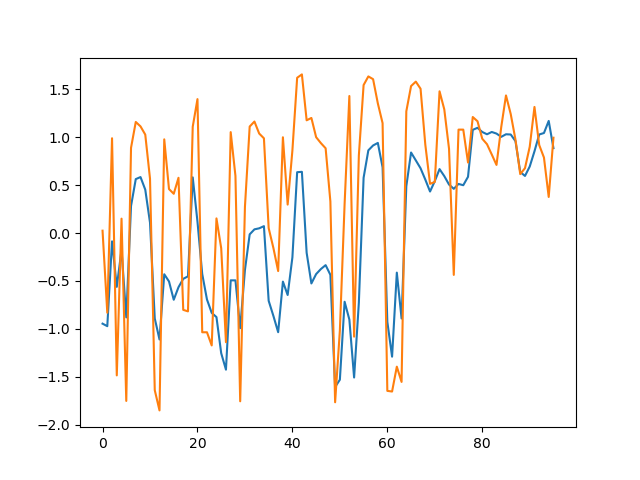

In [46]:
plt.figure()
plt.plot(chr_normedPC1, )
plt.plot(matched_pc1)

<IPython.core.display.Javascript object>


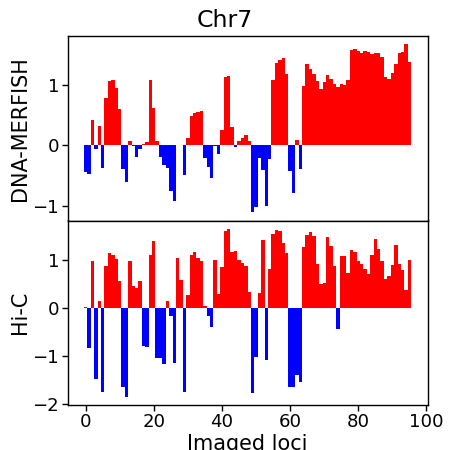

In [54]:
# plot
fig, axes = plt.subplots(2, 1, figsize=(_single_col_width, _single_col_width),
                         sharex=True, dpi=200)
ensemble_ax, hic_ax = axes
# 1
ens_AB_th = -0.5

ensemble_ax.bar(np.where(chr_normedPC1>ens_AB_th)[0], 
            chr_normedPC1[chr_normedPC1>ens_AB_th]-ens_AB_th, 
            color='r',width=1, bottom=0)
ensemble_ax.bar(np.where(chr_normedPC1<=ens_AB_th)[0], 
            chr_normedPC1[chr_normedPC1<=ens_AB_th]-ens_AB_th, 
            color='b',width=1, bottom=0)
ensemble_ax.set_ylabel('DNA-MERFISH', fontsize=_font_size, labelpad=1)

hic_AB_th = 0

hic_ax.bar(np.where(matched_pc1>hic_AB_th)[0], 
            matched_pc1[matched_pc1>hic_AB_th]-hic_AB_th, 
            color='r',width=1, bottom=0)
hic_ax.bar(np.where(matched_pc1<=hic_AB_th)[0], 
            matched_pc1[matched_pc1<=hic_AB_th]-hic_AB_th, 
            color='b',width=1, bottom=0)
hic_ax.set_ylabel('Hi-C', fontsize=_font_size, labelpad=1)
hic_ax.set_xlabel('Imaged loci', fontsize=_font_size, labelpad=1)


for _ax in axes:
    _ax.tick_params('both', labelsize=_font_size-1, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    labelleft=True,
                    pad=1, ) # remove bottom ticklabels for ax1
    [i[1].set_linewidth(_ticklabel_width) for i in _ax.spines.items()]

fig.suptitle(f'Chr{sel_chr}', fontsize=_font_size+1, )
fig.subplots_adjust(wspace=0.1, hspace=0., left=0.15, right=0.95, top=0.92, bottom=0.1)
fig.savefig(os.path.join(comp_figure_folder, f"ABcompartment_calling_chr{sel_chr}_ensembleContact_HiC.pdf"),
            transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()